In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import random
from tqdm import tqdm
import cv2
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import backend as K

In [3]:
TRAIN_PATH = "dataset/2d_slices/pre_processed_images/"
TRAIN_MASK_PATH = "dataset/2d_slices/masks/"
MODEL_SAVE = "model/"

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[2]
mask_train_ids = next(os.walk(TRAIN_MASK_PATH))[2]

In [5]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

In [6]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train=np.zeros((len(mask_train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype = np.float16)

In [7]:
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=TRAIN_PATH+"/"+id_
    img = np.load(path)
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_train[n]=np.expand_dims(img, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1176/1176 [01:15<00:00, 15.54it/s]


In [8]:
for n,id_ in tqdm(enumerate(mask_train_ids),total=len(mask_train_ids)):
    path=TRAIN_MASK_PATH+"/"+id_
    mask = np.load(path)
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    Y_train[n]=np.expand_dims(mask, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1176/1176 [01:33<00:00, 12.57it/s]


C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Smallest pixel in image is [28]
Largest pixel in image is [255]
Smallest pixel in mask is [0.]
Largest pixel in mask is [1.]


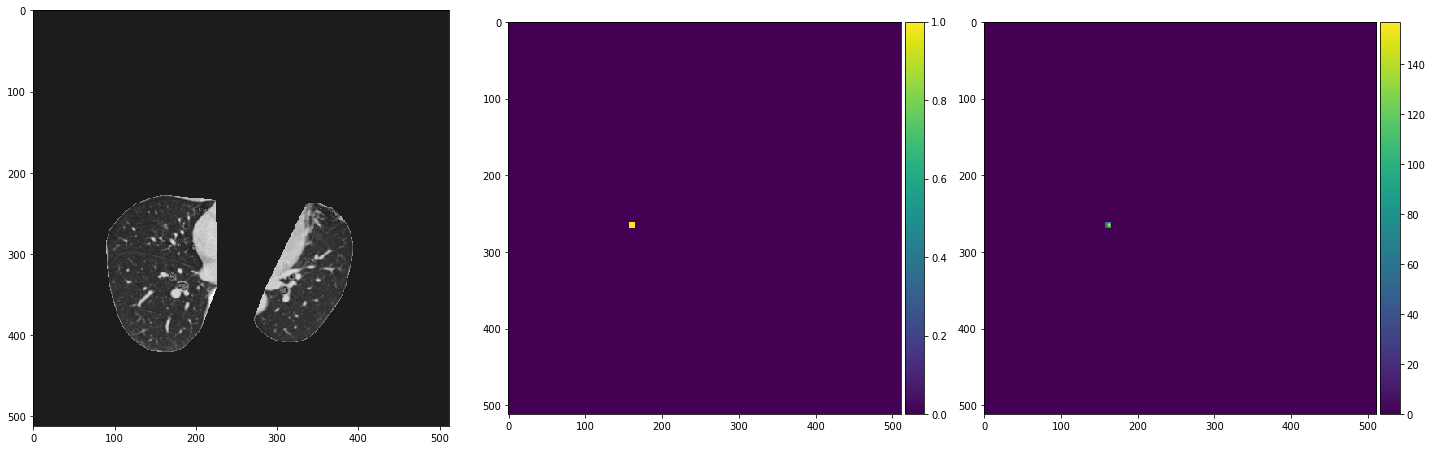

In [9]:
#Checking the training data
ix=random.randint(0,len(train_ids))
plt.figure(figsize=[20,10])
plt.subplot(131)
imshow(X_train[ix])
plt.subplot(132)
imshow(Y_train[ix])
plt.subplot(133)
imshow((X_train[ix])*Y_train[ix])
smallest = X_train[ix].min(axis=(0, 1))
largest = X_train[ix].max(axis=(0, 1))
print("Smallest pixel in image is",smallest)
print("Largest pixel in image is", largest)
smallest = Y_train[ix].min(axis=(0, 1))
largest = Y_train[ix].max(axis=(0, 1))
print("Smallest pixel in mask is",smallest)
print("Largest pixel in mask is", largest)


In [10]:
#https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
# def dice_coef(y_true, y_pred, smooth = 100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice
def dice_coef(y_true, y_pred, smooth = 1e-5):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_scores_tensor = (2. * intersection + smooth) / (union + smooth)
    mean_dice_score = tf.reduce_mean(dice_scores_tensor)
    return mean_dice_score

In [11]:
def dice_coef_loss_and_bce(y_true, y_pred):
    dice_loss = 1- dice_coef(y_true, y_pred) 
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
    term_1 = y_true * K.log(y_pred + K.epsilon())
    bce_loss = -K.mean(term_0 + term_1)
    mean = 0.7*(dice_loss) + 0.3*(bce_loss)
    return mean

In [12]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

In [13]:
s = tf.keras.layers.Lambda(lambda x:x / 255)(inputs)

In [14]:
channel_multipler = 2

### Constructing U NET

In [15]:
c1 = tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer = "he_normal",padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

In [16]:
c2=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)

In [17]:
c3=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

In [18]:
c4=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

In [19]:
c5=tf.keras.layers.Conv2D(256*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

In [20]:
#expansive path

In [21]:
u6 = tf.keras.layers.Conv2DTranspose(128*channel_multipler,(2,2),strides=(2,2),padding="same")(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)

In [22]:
u7=tf.keras.layers.Conv2DTranspose(64*channel_multipler,(2,2),strides=(2,2),padding="same")(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)

In [23]:
u8 = tf.keras.layers.Conv2DTranspose(32*channel_multipler,(2,2),strides=(2,2),padding="same")(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c8)


In [24]:
u9=tf.keras.layers.Conv2DTranspose(16*channel_multipler,(2,2),strides=(2,2),padding="same")(c8)
u9=tf.keras.layers.concatenate([u9,c1],axis=3)
c9=tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c9)


In [25]:
outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(c9)

In [26]:
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
model_unet=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model_unet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00003),loss=dice_coef_loss_and_bce,metrics=[dice_coef])
model_unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 32) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [27]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("./lungnodule_vanilla_changed.h5",verbose=1,save_best_only=True)

In [28]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=20,monitor="dice_coef"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

In [ ]:
 results = model_unet.fit(X_train,Y_train,validation_split=0.15,batch_size=32,epochs=150,callbacks=callbacks )

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
dice_coef = results.history['dice_coef']
val_dice_coef = results.history['val_dice_coef']
loss = results.history['loss']
val_loss = results.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(dice_coef) + 1)

plt.plot(epochs, dice_coef, 'b', label='Training dice coefficent',color="green")
plt.plot(epochs, val_dice_coef, 'b', label='Validation dice coefficient',color="blue")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.savefig('vanilla_train_diceloss_bs32.png')
plt.plot(epochs, loss, 'b', label='Training loss',color="green")
plt.plot(epochs, val_loss, 'b', label='Validation loss',color="blue")
plt.title('Training and validation loss')
plt.legend()
plt.savefig('vanilla_loss_diceloss_bs32.png')

plt.show()

#### Checking the model on random images

In [ ]:
idx = random.randint(0,len(X_train))

In [ ]:
preds_train = model_unet.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model_unet.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
#preds_test=model_unet.predict(X_t,verbose=1)

In [ ]:
#Each pixel is given a value between 0 and 1. We set a threshold 0.5 to binarize using thresholding

In [ ]:
preds_train_t = (preds_train >0.6).astype(np.uint8)
preds_val_t = (preds_val>0.6).astype(np.uint8)
#preds_test_t = (preds_test>0.6).astype(np.uint8)

In [ ]:
#Checking

In [ ]:
ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()
imshow(preds_train_t[ix])
plt.show()